Price a European up-and-out call option held with a risky counterparty. 

• The maturity of the option is in a year’s time <br>
• The option is struck at-the-money <br>
• The up-and-out barrier for the option is 150 <br> 
• The current share price is 100 <br>
• The risk-free continuously compounded interest rate is 8% <br>
• The volatility for the underlying share is 30% <br>
• The volatility for the counterparty’s firm value is 25% <br>
• The counterparty’s debt, due in one year, is 175 <br>
• The correlation between the counterparty and the stock is constant at 0.2 <br>
• The recovery rate with the counterparty is 25% <br>
• Assume V_0 = 100 <br>

# 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

In [2]:
##imports and constants
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
import numpy.matlib
import matplotlib.pyplot as plt
import math
import random

#Market, Stock and Option specific information
T = 1
barrier = 150
s0 = 100
strike = 100
risk_free_rate = .08
sigma = .3
sigma_firm = .25
debt = 175
correlation = .2
corr_matrix = [[1,correlation],[correlation,1]]

dT = 1/12
recovery_rate = .25
v0 = 100

#Function to simulate share paths and terminal share price
def orig_share_path(S0, risk_free_rate, sigma, Z, dT):
    """Generates the terminal share price given some random normal values Z"""
    return S0*np.exp(np.cumsum((risk_free_rate - sigma**2/2)*dT + sigma*np.sqrt(dT)*Z, 1))

def share_path(s0, risk_free_rate, sigma, Z, dT):
    """Generates the share path given some random normal values Z"""
    newZ = [1/len(Z)] * len(Z)
    #print(newZ)
    newZ = np.cumsum(newZ)
    #print(newZ)
    return s0*np.exp((risk_free_rate - sigma**2/2)*newZ + sigma*np.sqrt(newZ)*(Z))

def terminal_shareprice(S0, risk_free_rate, sigma, Z, T):
    """Generates the terminal share price given some random normal values, Z"""
    return S0*np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

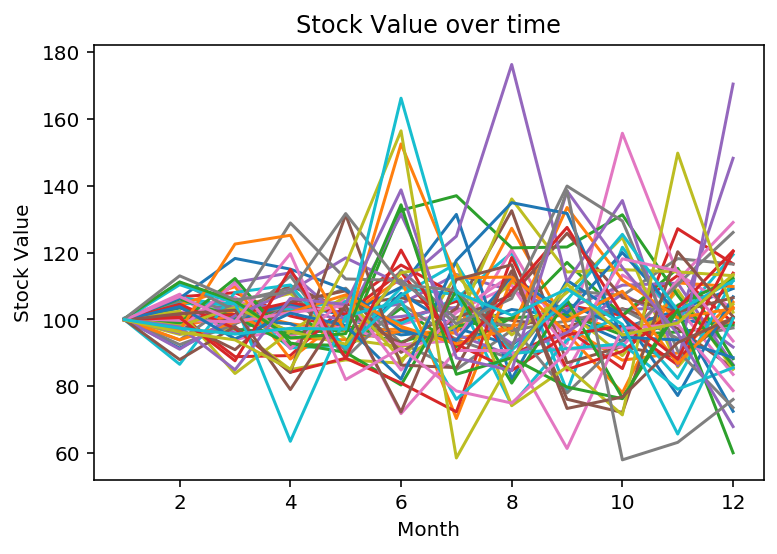

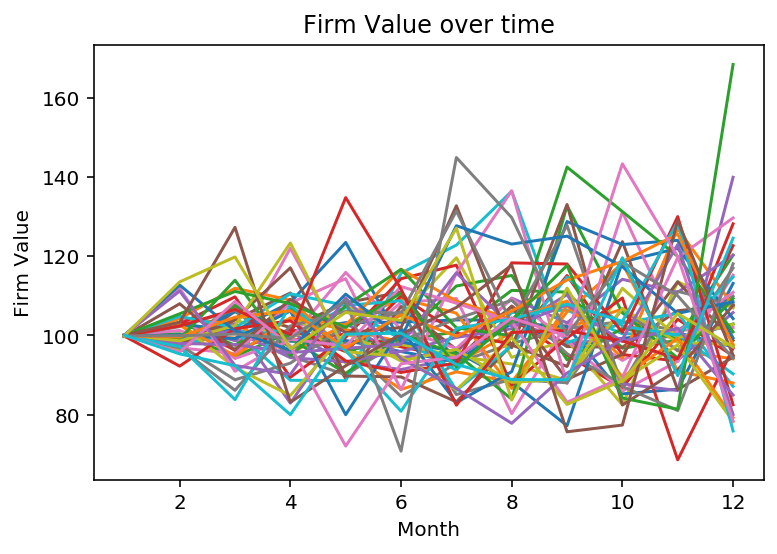

In [3]:
###simulate paths for the underlying share and firm value using sample sizes 1k...50k and divide that up into months...

np.random.seed(0)
sharepath = [None]  * 50
firmpath = [None]*50


for i in range(1,51):
    sharepath[i-1] = [None] * i * 1000
    norm_array = norm.rvs(size = i*1000)
    
    norm_matrix = norm.rvs(size = np.array([2,50000]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    sharepath[i-1] = share_path(s0, risk_free_rate, sigma, corr_norm_matrix[0,], dT)

    firmpath[i-1] = share_path(v0, risk_free_rate, sigma_firm, corr_norm_matrix[1,], dT)
    #print(sharepath[i-1][-1])
    
tick = 12

index = np.array(range(1,tick+1))
    
for i in range (1,51):
    #print(len(sharepath[i-1][:]))
    increment = i*1000//tick
    #print(range(0,i*1000,i*1000//12))
    #print(sharepath[i-1][0:increment * 12 :increment])
    plt.plot(index, sharepath[i-1][0:increment * tick - 1 :increment])
 
plt.title("Stock Value over time")
plt.xlabel("Month")
plt.ylabel("Stock Value")

plt.show()


for i in range (1,51):
    #print(len(sharepath[i-1][:]))
    increment = i*1000//(tick+1)
    #print(range(0,i*1000,i*1000//12))
    #print(sharepath[i-1][0:increment * 12 :increment])
    plt.plot(index, firmpath[i-1][0:increment * tick - 1 :increment])


    
plt.title("Firm Value over time")
plt.xlabel("Month")
plt.ylabel("Firm Value")

plt.show()

# 2.Monte Carlo Simulation for calculating CVA

In [4]:
# import all the necessary libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

#Market information 
risk_free_rate = 0.08

#Share specific information
S_0 = 100
sigma = 0.30

#Call option specific information
strike =100
T = 1
barrier_limit=150

#Firm specific information
V_0 = 200
sigma_firm = 0.25 
debt = 175
recovery_rate = 0.25 
correlation = 0.2

***It is necessary to create the functions which transform our random standard normals into terminal values. Note that we are going to be modeling our firm value in the same way which we have been modeling stock values – hence, we are going to be using the terminal_value function for both our stock and our firm. The call_payoff function finds the payoff for a call option at terminal time

In [5]:
#Utility Functions for later valuations
def terminal_value(S_0, risk_free_rate, sigma, Z, T):
    """Generate the terminal stock price given the random normal values, Z"""
    return S_0 * np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

def call_payoff(S_T, K):
    """Function for evaluating the payoff for call option at terminal time"""
    return max(S_T-K, 0)

 ***Since we are working within the Merton model, we are going to be simulating our assets using a standard normal distribution. We are using a sample size of 50 000 – this means that we have 50 000 estimates for our stock price and 50 000 estimates for our firm value. Given the correlation between shares and firm value as 0.2 we generate the correlated standard normal numbers using a Cholesky decomposition

In [6]:
#seed the values to 0 and calculate the correlation matrix between the stock and the counterparty's firm value
np.random.seed(0)

corr_matrix = np.array([[1, correlation], [correlation, 1]])
norm_matrix = norm.rvs(size = np.array([2, 50000]))
corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)

***Once we have our matrix of standard normal random numbers, we can generate our terminal stock and firm values. first create an array of stock values using the first row of the matrix of correlated standard normals. Note that this will create an array of 50 000 stock values. Then create an array of terminal firm values.

In [7]:
term_stock_val = terminal_value(S_0, risk_free_rate, sigma, corr_norm_matrix[0,],T)
call_val = term_stock_val * (term_stock_val > barrier_limit)
term_firm_val = terminal_value(V_0, risk_free_rate, sigma, corr_norm_matrix[1,],T) 

***With these terminal values generated, we can calculate our potential profit losses in each case. Losses occurs when the firm value falls below its outstanding debt, in which case we recover a percentage of outstanding which is called Recovery Rate. Finally CVA is calculated as mean of all sample generated losses.

In [8]:
amount_lost = np.exp(-risk_free_rate * T) * (1 - recovery_rate) * (term_firm_val < debt) * call_val
cva_estimate = np.mean(amount_lost)
cva_std = np.std(amount_lost)/np.sqrt(50000)
print("cva_estimate : ", cva_estimate)

#Code to calculate default probability
# d_1 = (np.log(V_0/debt) + (risk_free + sigma_firm**2/2) * (T))/(sigma_firm * np.sqrt(T))
# d_2 = d_1 - sigma_firm * np.sqrt(T)

# default_prob = norm.cdf(-d_2)

cva_estimate :  2.2580240310760042


# 3. Pricing an Up-and-Out Exotic Option (Counterparty Risk-free)

In [9]:
# An 'up-and-out' option is a type of barrier option. Specifically, the underlying price starts from below a barrier level. 
# Once it reaches the barrier it is knocked out. Below example prices an 'up-and-out' barrier option with an European Call:

In [10]:
# Steps for Monte Carlo Pricing of Up-and-Out Option:
# 1. Simulate the risk-neutral random walk for the entire period.
# 2. Compute the final payoff as long as it didn't breach the barrier.
# 3. Perform N times the two first steps
# 4. Take the average of all your payoffs

In [11]:
import numpy as np
import scipy as sp
#Functions for later valuations
def terminal_value(S_0, risk_free_rate, sigma, Z, T):
    """Generate the terminal stock price given the random normal values, Z"""
    return S_0 * sp.exp((risk_free_rate-sigma**2/2)*T+sigma*sp.sqrt(T)*Z)

def call_payoff(S_T, K):
    """Function for evaluating the call payoff in Monte Carlo Estimation"""
    return max(S_T-K, 0)

In [12]:
def blackscholes_call(S,X,T,rf,sigma):
    """
       Returns: Call value under Black-Schole-Merton option model
       Format   : blackscholes_call(S,X,T,r,sigma)
               S: current stock price
               X: exercise price
               T: maturity date in years
              rf: risk-free rate (continusouly compounded)
           sigma: volatiity of underlying security 
    """    
    from scipy import log,exp,sqrt,stats
    d1=(log(S/X)+(rf+sigma*sigma/2.)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    return S*stats.norm.cdf(d1)-X*exp(-rf*T)*stats.norm.cdf(d2)

In [13]:
def up_and_out_call(initial_stock_price, strike_price, T, risk_free_rate, sigma, n_simulation, barrier_limit):
    """
       Returns: Up and Out Call value uing Monte Carlo Simulation
       Format   : up_and_out_call(initial_stock_price, strike_price, T, risk_free_rate, sigma, n_simulation, barrier_limit)
               initial_stock_price: current stock price
               strike_price: exercise price
               T: maturity date in years
               risk_free_rate: risk-free rate (continusouly compounded)
               sigma: volatiity of underlying security
               n_simulation: Number of Monte Carlo simulations
               barrier_limit: Limit behind which the option expires worthless 
    """    
    n_steps=1000
    dt=T/n_steps
    total=0
    for j in range(0, n_simulation):
        S_T=initial_stock_price
        out=False
        for i in range(0,int(n_steps)):
            Z = sp.random.normal()
            S_T = terminal_value(S_T, risk_free_rate, sigma, Z, dt) #sp.exp((rfr-0.5*sigma*sigma)*dt+sigma*e*sp.sqrt(dt))
            if S_T > barrier_limit:
                out=True
        if out==False:
            total += blackscholes_call(S_T, strike_price,T,risk_free_rate,sigma) #max(S_T - strike_price, 0)
    return total/n_simulation

***We simulate 1000 times the stock movement. For each simulation, 1000 steps. Once, at some point, the stock price reaches the barrier, the payoff of the option will be zero. Otherwise, the value will be that of an European call under BS. The final value will be the mean value of all call prices that are not knocked out.

In [14]:
initial_stock_price=100 #spot price
exercise_price=100 # option exercise price
barrier_limit=150 # Up and Out barrier limit
T=1 # maturity in years 
rfr=0.08 # risk-free rate
sigma=0.3 # volatility (annualized) 
n_simulation=1000 # number of simulations 
np.random.seed(0)
risk_free_option_price=up_and_out_call(initial_stock_price, exercise_price, T, rfr, sigma, n_simulation, barrier_limit)# * sp.exp(-rfr * T) 
print('Risk free up-and-out call option value = ', risk_free_option_price)

Risk free up-and-out call option value =  12.921009409331496


# 4. Pricing an Up-and-Out Exotic Option (Counterparty Risk Imbibed)

*** Monte Carlo estimates for the price of the option incorporating counterparty risk. Its given by the default-free price less the CVA

In [16]:
risk_adjusted_option_price = risk_free_option_price - cva_estimate
print('Counterparty Deafult Risk Adjusted Value of up-and-out call option = ', risk_adjusted_option_price)

Counterparty Deafult Risk Adjusted Value of up-and-out call option =  10.662985378255492
